In [1]:
%load_ext autoreload
%autoreload 2

# init and load image

In [3]:
import os
import numpy as np 
from bokeh.plotting import show, output_notebook
import pandas as pd
import socket
os.chdir(path_to_tissue_tag)
import tissue_tag as tt
import matplotlib.pyplot as plt
import scanpy as sc
output_notebook()
host = '5011'

Loading BokehJS ...

# Step 1 - Load image and define objects annotation names and colors 

(1351, 1974)


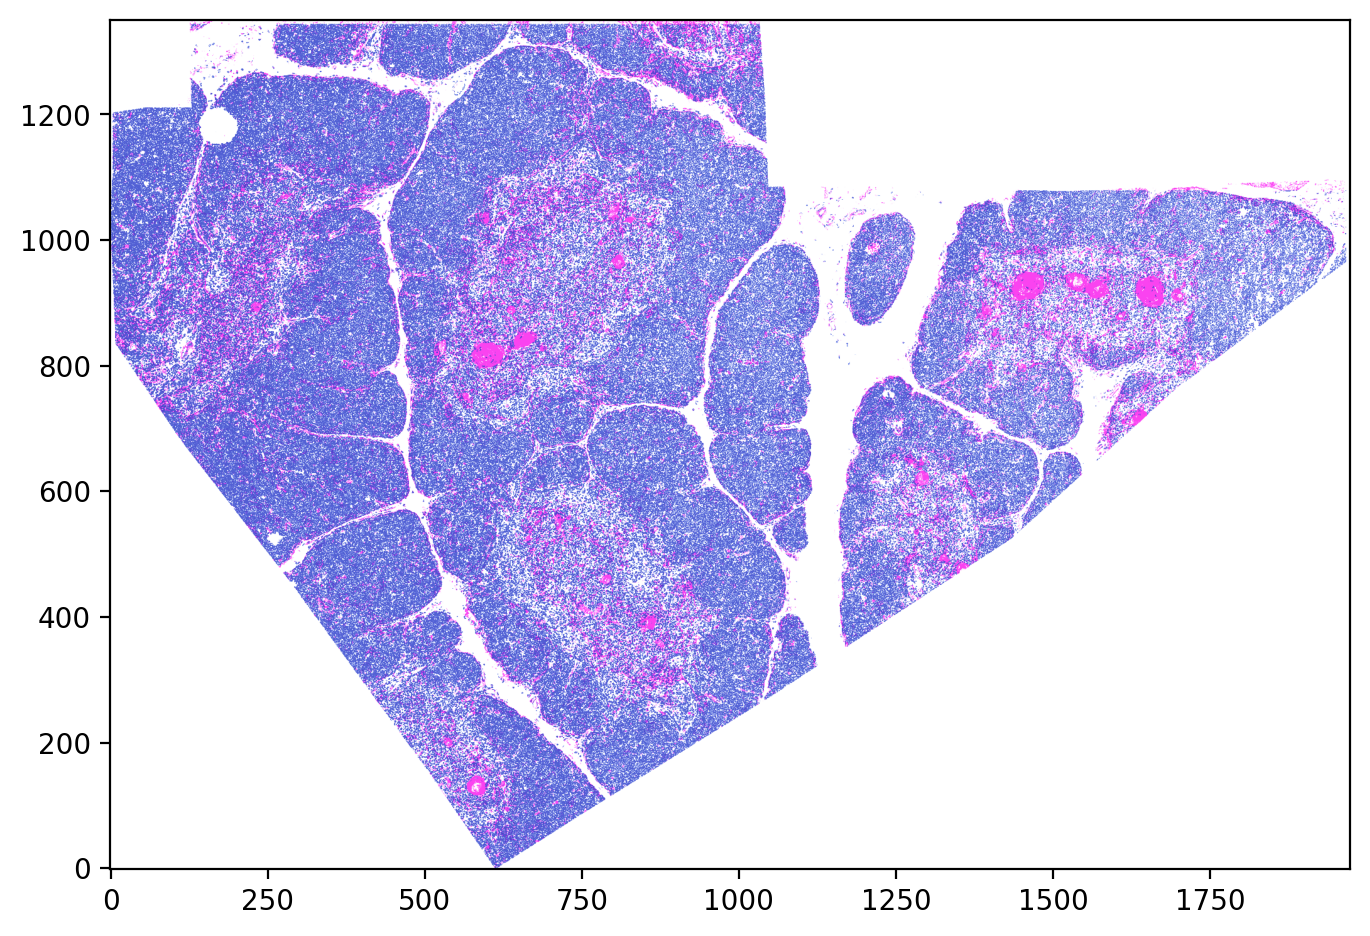

In [22]:
# here you can either read a single image (grayscale or RGB) or generate a virtial H&E from 2 images in the next cell
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
path = path_to_tissue_tag + 'data/tissue_tag_minimal_example_ibex/' 
im,_,ppm = tt.read_image(path+'Sample_05_THY45_Z5_ch0009.jpg',contrast_factor=2,background_image_path=path+'Sample_05_THY45_Z5_ch0058.jpg',ppm_image=3.52,ppm_out=0.5)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(im,origin='lower')
# plt.savefig('/nfs/team205/ny1/IBEX/Thymus/dapi.png')

plt.show()

# define annotations Lv0 
annodict = {
    'lobes':'red',
}

# Step 2- Manually draw annotations or Correct forest annotations (Step 2)

In [24]:
# tabs,render_dict = tt.annotator(im,out_img,anno_dict=annodict,fig_downsize_factor=int(3))
# at this stage, if you are adding annotations make sure they come after the current ones otherwise it will mess up everything
result = np.zeros((im.shape[0],im.shape[1]), dtype=np.uint8) # blank annotation image
result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5,show=False)
tabs,render_dict = tt.poly_annotator(im,out_img,anno_dict=annodict)

# plotting
def app(doc):
    global tabs
    doc.add_root(tabs)
show(app,notebook_url=f'{socket.gethostname()}:'+host)

## create annotations 

lobes


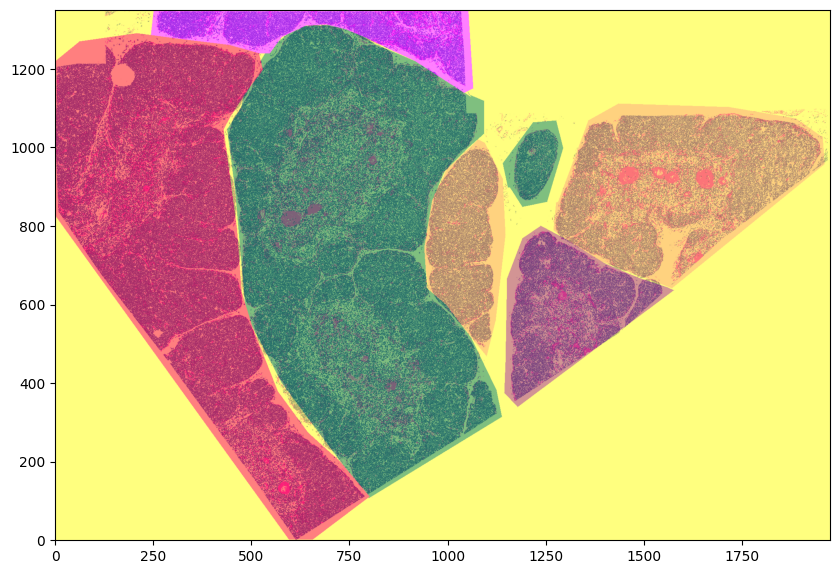

In [25]:
result,object_dict  = tt.object_annotator(im,result,anno_dict=annodict,render_dict=render_dict,alpha=0.5)
object_dict
# plot result 
result_rgb = tt.rgb_from_labels(result,colors=list(object_dict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5)

# Step 3 - save annotations

In [26]:
isExist = os.path.exists(path+'tissue_annotations')
if not(isExist):
    os.mkdir(path+'/tissue_annotations/')
    
tt.save_annotation(
    folder=path+'/tissue_annotations/',
    label_image=result,
    file_name='annotations_'+list(annodict.keys())[0],
    anno_names=list(object_dict.keys()),
    anno_colors=list(object_dict.values()),
    ppm = ppm,
    
)

# Step 4 - load annotations

loaded annotation image - annotations_lobes size - (1351, 1974)
loaded annotations
{1: 'unassigned', 2: 'lobes_0', 3: 'lobes_1', 4: 'lobes_2', 5: 'lobes_3', 6: 'lobes_4', 7: 'lobes_5', 8: 'lobes_6', 9: 'lobes_7', 10: 'lobes_8'}
loaded ppm
{'ppm': 0.5}
loaded color annotations
{'unassigned': 'yellow', 'lobes_0': 'orange', 'lobes_1': 'brown', 'lobes_2': 'green', 'lobes_3': 'orange', 'lobes_4': 'orange', 'lobes_5': 'green', 'lobes_6': 'magenta', 'lobes_7': 'red', 'lobes_8': 'red'}
(1351, 1974)
[ 1  2  3  4  5  6  7  8  9 10]


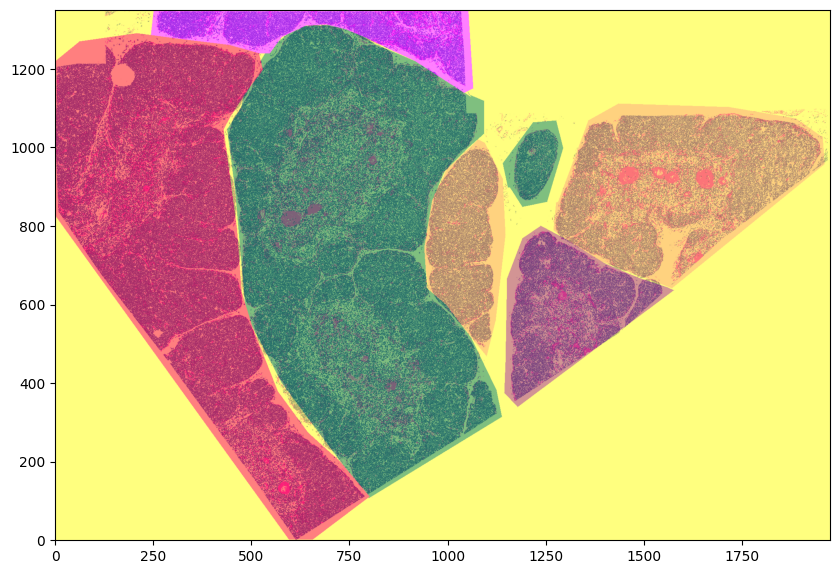

In [27]:
# load tissue annotations from jupyter annotator 
annotation_image,annotations_labels,ppm,annodict = tt.load_annotation(path+'/tissue_annotations/','annotations_lobes',load_colors=True)
im,ppm_image,_ = tt.read_image(path+'Sample_05_THY45_Z5_ch0009.jpg',contrast_factor=2,background_image_path=path+'Sample_05_THY45_Z5_ch0058.jpg',ppm_image=3.52,ppm_out=ppm)
result_rgb = tt.rgb_from_labels(annotation_image,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5)
print(np.unique(annotation_image))

## migrate annotations to hi res grid sapce 


In [28]:
%%time
# it's critical not to split cell part and recalculate the df everytime you cahnge the dist2cluster resolution - I have an overflow bug somewhere that I need to fix
spot_diameter = 20 # don't go crazy here avoid under 15um spots 
df = tt.grid_anno(
    im,
    [annotation_image],
    ['annotations'],
    [annotations_labels],
    spot_diameter=spot_diameter,
    ppm_in=ppm,
    ppm_out=ppm_image,
)
df

generating grid with spot size - 20, with resolution of - 0.5 ppm
annotations


26730it [00:03, 7977.57it/s]


CPU times: user 3.42 s, sys: 4.42 ms, total: 3.43 s
Wall time: 3.76 s


x            y annotations  annotations_number
index                                                       
0         70.40    70.400000  unassigned                   1
1         70.40   140.327169  unassigned                   1
2         70.40   210.254325  unassigned                   1
3         70.40   280.181494  unassigned                   1
4         70.40   350.108650  unassigned                   1
...         ...          ...         ...                 ...
26725  13826.56  9196.131484  unassigned                   1
26726  13826.56  9266.058828  unassigned                   1
26727  13826.56  9335.985313  unassigned                   1
26728  13826.56  9405.912656  unassigned                   1
26729  13826.56  9475.840000  unassigned                   1

[26730 rows x 4 columns]

In [80]:
# remove background spots
# df = df.iloc[np.where(df['annotations']!='unassigned')[0],:]

## move annotation and distances to cells (or anything that has xy coordinates)  

In [35]:
# read cell data 
df_cells = pd.read_csv(path+'sample_05_xy.csv')
df_cells


Unnamed: 0   centroid-0   centroid-1
0                0    21.049881  4322.589074
1                1    40.732535  4327.992016
2                2    40.332468  4362.800000
3                3    45.308157  4345.679758
4                4    52.028721  4311.151436
...            ...          ...          ...
112168      112168  9466.446809  3947.117021
112169      112169  9466.835366  4922.692073
112170      112170  9467.217514  6774.098870
112171      112171  9466.623288  2953.948630
112172      112172  9466.861111  6528.008333

[112173 rows x 3 columns]

make sure the coordinate systems are aligned e.g. axes are not flipped


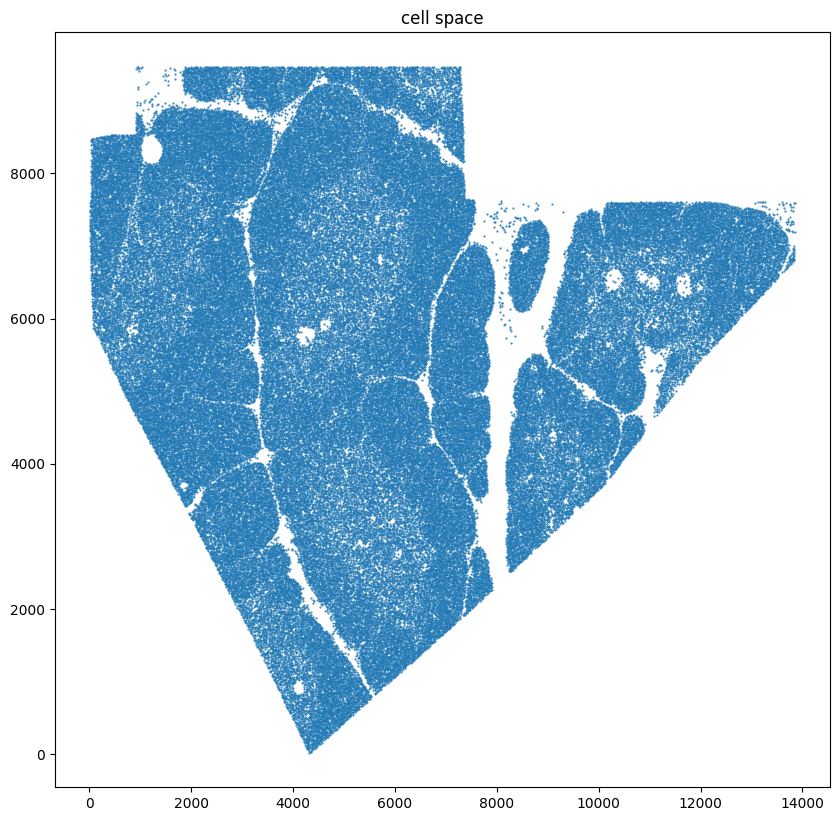

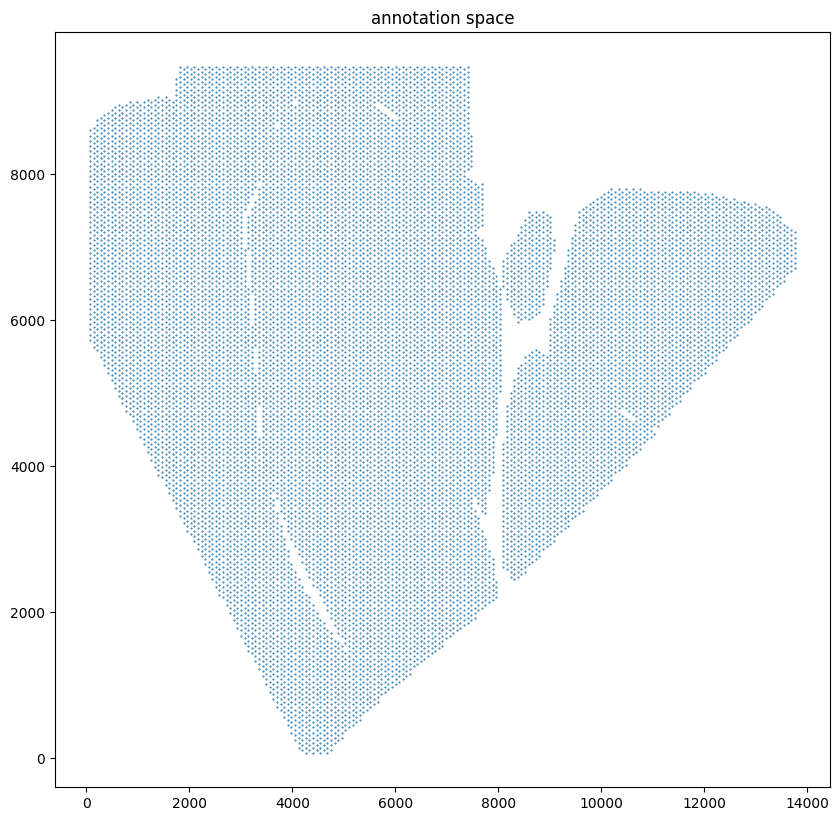

migrating - annotations to segmentations
migrating - annotations_number to segmentations


Unnamed: 0   centroid-0   centroid-1 annotations  annotations_number
0                0    21.049881  4322.589074     lobes_8                  10
1                1    40.732535  4327.992016     lobes_8                  10
2                2    40.332468  4362.800000     lobes_8                  10
3                3    45.308157  4345.679758     lobes_8                  10
4                4    52.028721  4311.151436     lobes_8                  10
...            ...          ...          ...         ...                 ...
112168      112168  9466.446809  3947.117021     lobes_6                   8
112169      112169  9466.835366  4922.692073     lobes_6                   8
112170      112170  9467.217514  6774.098870     lobes_6                   8
112171      112171  9466.623288  2953.948630     lobes_6                   8
112172      112172  9466.861111  6528.008333     lobes_6                   8

[112173 rows x 5 columns]

In [36]:
# calculate distance matrix between hires and visium spots
df_cells = tt.anno_to_cells(
    df_cells=df_cells,
    x_col='centroid-1', 
    y_col='centroid-0',
    df_grid=df, 
    annotation = 'annotations',
    plot=True
)
df_cells

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


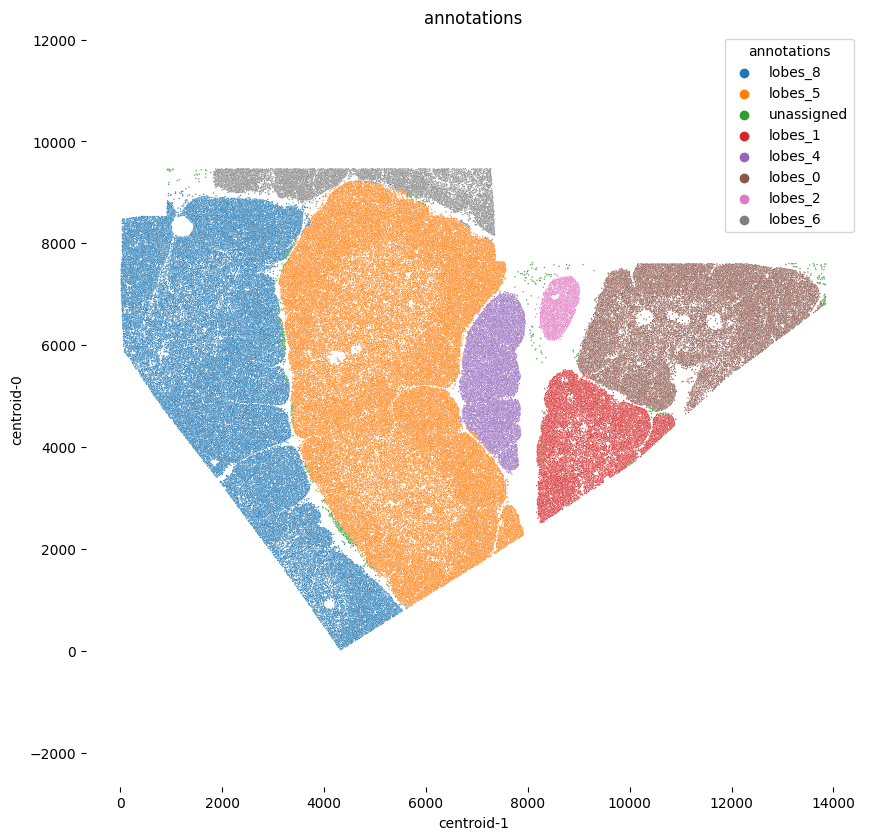

In [37]:
import seaborn as sns
plt.figure(dpi=100, figsize=[10,10])
sns.scatterplot(df_cells['centroid-1'],df_cells['centroid-0'],hue= df_cells['annotations'],cmap='tab10',s=1)
plt.grid(False)
plt.title('annotations')
plt.axis('equal')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()